In [12]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from bs4.element import Tag
import bs4
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
from lxml import html
import lxml
import collections.abc as clct

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Overview
- Food is one of the most common topics on the internet, with content being published on the web by big businesses such as *foodnetwork* and *allrecipes* to home chefs writing their own blogs. 
- Food is trendy--keeping on top of food trends could be valuable to people who write about food and publish recipes.
### A utility pastry recipe web scraper
- Can one write a utility web scraper to grab recipes from websites that is general enough to work across a variety of website and copy structures?
### Turning the recipe documents into vectors for a supervised machine learning classifier problem
- How well do the recipe instructions predict the type of recipe?
- If the predictive power is good, what are the key words that the model is relying upon?
- Can an unsupervised model look within a particular recipe class to identify different schools of thought for that particular product? E.g. Can it identify different types of croissant recipes?
### Looking towards the future
- Can a model that scrapes the web to keep the pulse on the food world detect differences in regional food culture? Can a model identify changes in food trends before they are generally recognized by the public? Can a model uncover interesting, yet poorly recognized food histories?
### Goals
- Generate a list of target websites for a particular recipe class by pulling urls from Google search
- Develop a utility scraper to identify recipes and then grab pertinent information about the recipe from the recipe section--starting with instructions
- Test the results of the scraper on a supervised model that classifies the vectorized recipes
- Explore the possibiliity of identifying different groupings within a specific recipe class

## Tools and techniques used in this project
- **Tools**
> - Python, Beautiful Soup, Pandas, Numpy, Gensim
- **Visualization**
> - Matplotlib, Plotly
- **Techniques**
> - Web-scraping, Multinomial Naive Bayes Classification, Non-negative Matrix Factoring (NMF)


In [14]:
def get_links_from_google_search(google_url):
    '''
    Given a Google search string, returns links from that Google search page
    Parameters:
    ----------
    google_url (str): a google search string. To get past the first page, replace start=0 with start={bundle}.
    Returns:
    -------
    links (list): a list of links 
    '''
    links_ = []
    driver = webdriver.Firefox()
    time.sleep(30) # slow requests down to keep google from getting upset
    driver.get(google_url)
    soup = BeautifulSoup(driver.page_source,'lxml')
    result_div = soup.find_all('div', attrs={'class': 'g'})
    for r in result_div:
            try:
                link = r.find('a', href=True)
                if link != '':
                    # site exceptions
                    if 'google.' not in link and 'costco.' not in link and 'freshdirect' not in link: 
                        links_.append(link['href'])
                
            except Exception as e:
                print(e)
                continue
    return(links_)


## Step one
### Get links for the target search term

In [ ]:
#  The easiest way to change the search is to type a search in google then COPY and PASTE the address. If you try to assign variable to the function call it won't recognize {bundle}.
#  Convert to an f string, find start=0 in the string and change it to start={bundle}.

# us_brioche = f'https://www.google.com/search?q=how+to+make+brioche+dough&client=ubuntu&hs=Do3&channel=fs&sxsrf=ALeKk03eqUHI6tXD0_aUHZKqzJUzujjeZQ:1598546700864&ei=DONHX56eNIXB-wS2mZvwBw&start={bundle}&sa=N&ved=2ahUKEwie1IvC6rvrAhWF4J4KHbbMBn4Q8NMDegQIDhBA&biw=1637&bih=942'
# us_puff_pastry = f'https://www.google.com/search?q=how+to+make+puff+pastry+dough&client=ubuntu&hs=GNM&channel=fs&sxsrf=ALeKk011tOIIja512_JwZ8zfTmHSiLc9HA:1598459179879&ei=K41GX96hNcP7-gTrwZCYAg&start={bundle}&sa=N&ved=2ahUKEwie4-q8pLnrAhXDvZ4KHesgBCMQ8NMDegQIDhBA&biw=1637&bih=942'
# us_ciambellone = f'https://www.google.com/search?q=how+to+make+ciambellone&client=ubuntu&hs=GlP&channel=fs&sxsrf=ALeKk03eb_8FF-pe9XNVMG56gUih10WpYA:1598472199741&ei=B8BGX83oLIvJ0PEPr-2ryAQ&start={bundle}&sa=N&ved=2ahUKEwiNiJj91LnrAhWLJDQIHa_2CkkQ8NMDegQIDBBA&biw=1637&bih=942'
# us_google_url=f"https://www.google.com/search?q=croissant+baking+temp&client=ubuntu&hs=bju&channel=fs&tbas=0&sxsrf=ALeKk01tinXVzgWJgZhSeeUfjrJd4FW4oA:1597161338731&ei=er8yX--YLLi50PEPiYu28A4&start={bundle}&sa=N&ved=2ahUKEwjvvfnRwZPrAhW4HDQIHYmFDe4Q8NMDegQIDhBA&biw=1920&bih=969"
# fr_google_url=f"https://www.google.fr/search?q=temp%C3%A9rature+cuisson+croissant&ei=0PEzX4C2PMXk-gTv_ImwCA&start={bundle}&sa=N&ved=2ahUKEwiA3szk5ZXrAhVFsp4KHW9-AoYQ8NMDegQIDRBC&biw=1848&bih=942"
# uk_google_url=f"https://www.google.co.uk/search?q=croissant+temperature&ei=OPQzX8T0KMj4-gSnn5moBw&start={bundle}&sa=N&ved=2ahUKEwjE8JaK6JXrAhVIvJ4KHadPBnUQ8NMDegQIDhA_&biw=1848&bih=942"

target_links = 120
page_bundles = list(range(0,target_links,10))
brioche_links=[]
for bundle in page_bundles:
    links_list = get_links_from_google_search(f'https://www.google.com/search?q=how+to+make+brioche+dough&client=ubuntu&hs=Do3&channel=fs&sxsrf=ALeKk03eqUHI6tXD0_aUHZKqzJUzujjeZQ:1598546700864&ei=DONHX56eNIXB-wS2mZvwBw&start={bundle}&sa=N&ved=2ahUKEwie1IvC6rvrAhWF4J4KHbbMBn4Q8NMDegQIDhBA&biw=1637&bih=942')
    for link in links_list:
        brioche_links.append(link)

In [ ]:
len(brioche_links)

### Write results to file from Google search function

In [ ]:
# Uncomment country to write results

# uk_croissant_links = pd.DataFrame(links)
# uk_croissant_links.to_csv('data/uk-croissant-links.txt')

# us_brioche_links = pd.DataFrame(brioche_links)
# us_brioche_links.to_csv('data/us-brioche-links.txt')

# us_croissant_links = pd.DataFrame(links)
# us_croissant_links.to_csv('data/us-croissant-links.txt')

# us_puff_pastry_links = pd.DataFrame(puff_links)
# us_puff_pastry_links.to_csv('data/us-puff-pastry-links.txt')

# us_cake_pastry_links = pd.DataFrame(cake_links)
# us_cake_pastry_links.to_csv('data/us-ciambellone-links.txt')

# fr_croissant_links = pd.DataFrame(links)
# fr_croissant_links.to_csv('data/fr-croissant-links.txt')

## Step two
### A focus on pastry recipes
- I chose to start with pastry recipes since I come with an indepth knowledge of this space. I've explored hundreds of pastry recipe websites over my career.
- I chose four categories of pastry and baked goods recipes that had what I considered to be important differences, yet enough similarity that they might confuse a model.

### Numerous ways to format a recipe, but some intriguing similarities make a utility scraper possible
- My initial Google search website 'spider' yielded more than recipe websites--I needed a scraper that would limit the possibility of seeing a recipe when one wasn't there
- More than a third of recipes I encountered follow a schema format promoted by Yoast, a website schema publisher to aid in SEO optimization--useful tags and a json structure with standardized keys for things like recipe ingredients and instructions (Yeah!)
- Another 40-50% placed the body of their recipe in a script tag with one of several commonly used attributes. This wasn't as clean of an approach--I usually ended up with extra text--but I still was able to get some results
- The rest, well, some didn't want to be scraped, and some had unusual structures. I could spend a lot of time chasing the tail with limited utility.
- Results:
- First pass links from Google search | Usable recipes obtained |  Yield
- Brioche     | 112    55    | 49%
- Ciambellone | 116   55     |  47%
- Croissant   | 180   72     | 40%
- Puff pastry | 200   86     | 43%

### Read in links file and initiate web scrape
- 

In [21]:
# url_list = pd.read_csv('data/fr-croissant-links.txt',header=None)
# url_list = pd.read_csv('data/uk-croissant-links.txt',header=None)
url_brioche = pd.read_csv('data/us-brioche-links.txt',header=None)
url_puff = pd.read_csv('data/us-puff-pastry-links.txt',header=None)
url_csnt = pd.read_csv('data/us-croissant-links.txt', header=None)
url_cake = pd.read_csv('data/us-ciambellone-links.txt', header=None)

search_string_1 = r'([A-Z][^.]*(?:reheat|ake|oven)[^.]*\d{3}(?:º|°|F| ºF| °F| F|C| ºC| °C| C)[^.]*(?:[.]|[\s]))' #US regex
search_string_2 = r'(\d{3})'

In [27]:
from scraper import *

brioche_scraper = ScrapeRecipe(page_genus='bread', page_species='brioche', re_pattern_1=search_string_1, re_pattern_2= search_string_2)

req_list = []
for i in range(1,20):
    req_list.append(brioche_scraper.process_url(url_brioche[1][i], verbose=True, extract_lang=True))
    


 Success with code 200 at URL: https://www.allrecipes.com/recipe/17486/brioche/
 Failure with code 200 at URL: https://www.kingarthurbaking.com/blog/2009/02/22/brioche-bring-it-on
 Failure with code 200 at URL: https://www.chicagotribune.com/news/ct-xpm-1986-12-11-8604020475-story.html
 Success with code 200 at URL: https://www.bakefromscratch.com/basic-brioche-dough/
 Success with code 200 at URL: https://www.bonappetit.com/recipe/brioche-dough
 Success with code 200 at URL: https://www.delish.com/cooking/recipe-ideas/a28848483/brioche-bread-recipe/
 Success with code 200 at URL: https://www.allrecipes.com/recipe/17486/brioche/
 Success with code 200 at URL: https://www.finecooking.com/recipe/authentic-brioche
 Success with code 200 at URL: https://www.kingarthurbaking.com/recipes/brioche-recipe
 Success with code 200 at URL: https://www.fifteenspatulas.com/homemade-brioche-oh-glorious-buttery-brioche/
 Failure with code 200 at URL: https://www.epicurious.com/recipes/food/views/brioch

In [36]:
BeautifulSoup(requests.get(req_list[2].url).content)

<!DOCTYPE html>
<html lang="en-US">
<head itemid="" itemscope="" itemtype="http://schema.org/SpeakableSpecification">
<title>LICKING THE BRIOCHE BUTTER PROBLEM - Chicago Tribune</title>
<meta charset="utf-8"/>
<link href="//www.trbimg.com" rel="dns-prefetch"/><link href="//www.trbimg.com" rel="preconnect"/><link href="//static.chartbeat.com" rel="dns-prefetch"/><link href="//m.trb.com" rel="dns-prefetch"/><link href="//m.trb.com" rel="preconnect"/><link href="//b.scorecardresearch.com" rel="dns-prefetch"/><link href="//b.scorecardresearch.com" rel="preconnect"/><link href="//securepubads.g.doubleclick.net" rel="dns-prefetch"/><link href="https://securepubads.g.doubleclick.net" rel="preconnect"/><link href="//pubads.g.doubleclick.net" rel="dns-prefetch"/><link href="//pubads.g.doubleclick.net" rel="preconnect"/><link href="//tpc.googlesyndication.com" rel="dns-prefetch"/><link href="//tpc.googlesyndication.com" rel="preconnect"/><link href="//www.google-analytics.com" rel="dns-prefetch"

In [56]:
good_url, bad_url, instr, target = [], [], [], []
hits, misses = 1,1
for page in brioche_recipes:
    if page != None:
        if page.instructions:
            if len(page.instructions)>0:
                good_url.append(page.url)
                instr.append(page.instructions)
                target.append(page.page_species)
                hits += 1
                       
            else:
                print(page.url)
                print("NO DATA")
                bad_url.append(page.url)
                misses += 1
print(f': Hits {hits}  Misses {misses}')

df_brioche = pd.DataFrame([good_url, instr, target]).T
# df = pd.DataFrame([good_url, instr, init_temp]).T

: Hits 56  Misses 1


In [57]:
df_brioche.iloc[:, 2] = 'brioche'
df_brioche.iloc[:, 1]

0     In a small bowl, dissolve yeast in warm water....
1     Combine 1/4 cup warm water and warm milk in bo...
2     Make the sponge: To the bowl of a stand mixer ...
3     In a small bowl, dissolve yeast in warm water....
4     In a stand mixer fitted with the paddle attach...
5     In a stand mixer or bread machine (programmed ...
6     Start with the sponge. Place the milk, yeast, ...
7     YieldMakes about 1 1/4 poundsIngredientsFor st...
8     Let the butter soften: About an hour before yo...
9     Put the milk, yeast, egg and 1 cup of the flou...
10    In a large mixing bowl, add in the flour, inst...
11    Hydrate the yeast. Mix yeast packet with the w...
12    The secret is homemade stored dough, mixed and...
13    \n\n\n\n\n\n\nBrioche Recipe & Video\n\n\n\n\n...
14    Add the yeast, milk, and 1 tablespoon sugar in...
15    In a stand mixer fitted with the paddle attach...
16    \nEveryone knows of Marie Antoinette’s famous ...
17    Combine the milk, sugar and yeast in the b

### Write search results to file

In [58]:
# Write results to csv

us_brioche = pd.DataFrame(df_brioche)
us_brioche.to_csv('data/us_brioche.csv')

# us_puff = pd.DataFrame(df_puff)
# us_puff.to_csv('data/us_puff.csv')

# us_croissant = pd.DataFrame(df_csnt)
# us_croissant.to_csv('data/us_croissant.csv')

# us_ciambellone = pd.DataFrame(df_cake)
# us_ciambellone.to_csv('data/us_ciambellone.csv')


In [59]:
us_brioche

,0,1,2
0,https://www.allrecipes.com/recipe/17486/brioche/,"In a small bowl, dissolve yeast in warm water....",brioche
1,https://www.bonappetit.com/recipe/brioche-dough,Combine 1/4 cup warm water and warm milk in bo...,brioche
2,https://www.delish.com/cooking/recipe-ideas/a2...,Make the sponge: To the bowl of a stand mixer ...,brioche
3,https://www.allrecipes.com/recipe/17486/brioche/,"In a small bowl, dissolve yeast in warm water....",brioche
4,https://www.finecooking.com/recipe/authentic-b...,In a stand mixer fitted with the paddle attach...,brioche
5,https://www.kingarthurbaking.com/recipes/brioc...,In a stand mixer or bread machine (programmed ...,brioche
6,https://www.fifteenspatulas.com/homemade-brioc...,"Start with the sponge. Place the milk, yeast, ...",brioche
7,https://www.epicurious.com/recipes/food/views/...,YieldMakes about 1 1/4 poundsIngredientsFor st...,brioche
8,https://www.thekitchn.com/how-to-make-brioche-...,Let the butter soften: About an hour before yo...,brioche
9,https://www.food.com/recipe/brioche-51546,"Put the milk, yeast, egg and 1 cup of the flou...",brioche


## Results and visualizations
- Of the 100 links obtained from the Google search by country, 35-40 usable temperatures were obtained for the US distribution and for the French distribution.
- Only 10 usable temperatures were obtained for the UK distribution. This is likely due to many recipes of US origin appearing in the google.uk search and being filtered out due to the restriction that temps needed to be expressed primarily in celsius.
- Mean temperatures are similar for all three countries.
- The distributions are different for the countries with the US having a narrower distribution of initial baking temperature and the French distribution being wider.

In [132]:
data_us = pd.read_csv('data/us_results.csv',header=None)
data_uk = pd.read_csv('data/uk_results.csv',header=None)
data_fr = pd.read_csv('data/fr_results.csv',header=None)

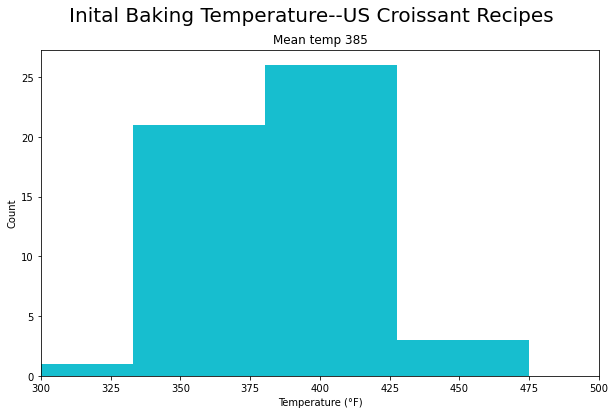

In [139]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(data_us.iloc[:,3], color='tab:cyan')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--US Croissant Recipes', size =20)
ax.set_title(f'Mean temp {data_us.iloc[:,3].mean():.0f}')
plt.savefig('img/us-croissant-baketemp-distribution.png')


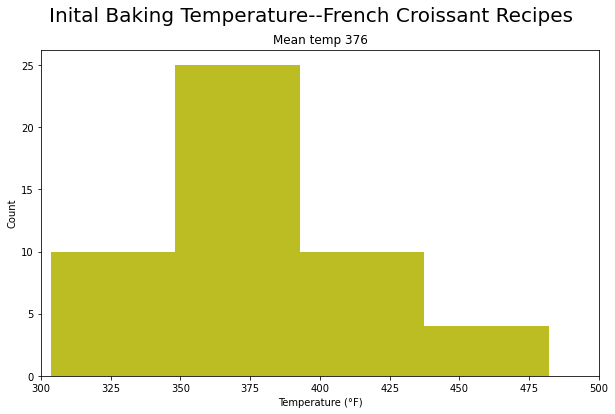

In [140]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist((data_fr.iloc[:,3]*9/5+32), color='tab:olive')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--French Croissant Recipes', size =20)
ax.set_title(f'Mean temp {(data_fr.iloc[:,3]*9/5+32).mean():.0f}')
plt.savefig('img/fr-croissant-baketemp-distribution.png')
# (data_uk.iloc[:,2]*9/5+32).hist()
# (data_fr.iloc[:,2]*9/5+32).hist()


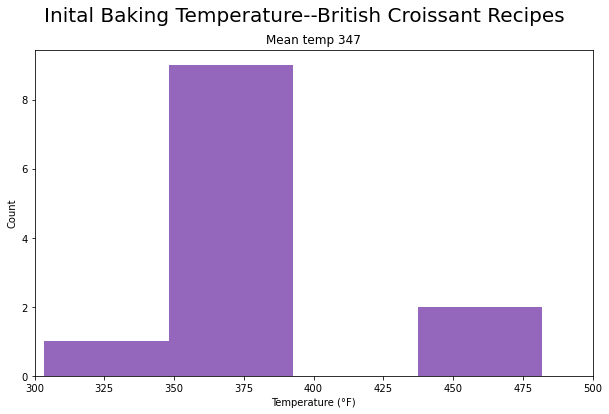

In [141]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist((data_uk.iloc[:,3]*9/5+32), color='tab:purple')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--British Croissant Recipes', size =20)
ax.set_title(f'Mean temp {(data_uk.iloc[:,3]*9/5+32).mean():.0f}')
plt.savefig('img/uk-croissant-baketemp-distribution.png')


## Future Research
- Seek to obtain more usable temperatures by grabbing more links from Google and/or by refining the sifting of the websites to obtain a better yield.
- Consider how best to compare the distributions.
- Explore other parameters of croissant preparation and baking.
- Explore the comments for the various websites to determine if people in the respective countries interact differently with recipe authors.